In [22]:
import pandas as pd
import numpy as np
import string
import re
import nltk

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import matplotlib.pyplot as plt

In [23]:
# NLTK Stop words
def set_stop_word(extended_words):
    stop_words = set(stopwords.words('english'))
    stop_words.update(extended_words)
    
    return stop_words

extended_words = ['paypal', 'app', 'money', 'cant', 'im', 'ive']
stopwords = set_stop_word(extended_words)

In [24]:
# 데이터 클렌징
def preprocess_text(text_data, get_lemma = True, tags=(), stop_words=[]):
    # 소문자 변경
    text_data = text_data.lower()
    # url 제거
    text_data = re.sub(r"http\S+|www.\S+|https\S+", r'', text_data)
    # html 태그 제거
    text_data = re.sub(r'<[^>]+>', r'', text_data)
    # 특수문자 제거
    text_data = re.sub(r'[^\w\s]', r'', text_data)
    # 숫자 제거
    text_data = re.sub(r'[0-9]\S+', r'', text_data)
    # 문장부호 제거
    text_data = [char for char in text_data if char not in string.punctuation]
    text_data = ''.join(text_data)
    # 금지어 제거
    text_data = [word for word in text_data.split() if word.lower() not in stop_words]
    text_data = ' '.join(text_data)
    # lemmatization
    if get_lemma==True:
        text_data = [lemmatizer.lemmatize(word) for word in text_data.split()]
        text_data = ' '.join(text_data)
    return text_data

In [25]:
# gensim의 simple_preprocess를 이용하여 전처리
def sent_to_words(sentences):
    for sent in sentences:
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True)
        yield(sent)

In [26]:
# N-gram 전처리
def process_ngram(data_words):
    # Build the bigram and trigram models
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)

    data_words = [[word for word in simple_preprocess(str(doc)) if word not in stopwords] for doc in data_words]
    data_words = [bigram_mod[doc] for doc in data_words]
    data_words = [trigram_mod[bigram_mod[doc]] for doc in data_words]
    
    return data_words

In [27]:
# 카운터 기반 사전 필터링
def filter_dictionary_by_count(min_count, documents, dictionary):
    from collections import Counter
    word_counter = Counter((word for words in documents for word in words))
    removal_word_idxs = {
        dictionary.token2id[word] for word, count in word_counter.items() if count < min_count
    }
    dictionary.filter_tokens(bad_ids=removal_word_idxs)
    dictionary.compactify()
    print('dictionary size: %d', len(dictionary))
    return dictionary

In [28]:
# data load
filename = "C:/Users/Edward/Downloads/paypal_reviews.csv"

df = pd.read_csv(filename)

print(df.shape)
print(df.info())
print(df.head(5))

(3220, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3220 entries, 0 to 3219
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   content     3220 non-null   object
 1   score       3220 non-null   int64 
 2   date        3220 non-null   object
 3   word_count  3220 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 100.8+ KB
None
                                             content  score  \
0  "suspicious account activity detected" what a ...      1   
1  I have changed my phone. On reinstalling the P...      1   
2  Absolute trash, it insists I live in the US an...      1   
3  Been using PayPal for years, this recent updat...      1   
4  It's been 6 hour I am trying to reach u all . ...      1   

                  date  word_count  
0  2024-11-23 09:51:27          52  
1  2024-11-23 09:44:16          46  
2  2024-11-23 06:58:48          50  
3  2024-11-23 06:39:16          94  
4  2024-11-23 05:02:56 

In [29]:
data = df.dropna(subset=['content']).copy()

In [30]:
print(data.shape)
print(data.info())
print(data.head(5))

(3220, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3220 entries, 0 to 3219
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   content     3220 non-null   object
 1   score       3220 non-null   int64 
 2   date        3220 non-null   object
 3   word_count  3220 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 100.8+ KB
None
                                             content  score  \
0  "suspicious account activity detected" what a ...      1   
1  I have changed my phone. On reinstalling the P...      1   
2  Absolute trash, it insists I live in the US an...      1   
3  Been using PayPal for years, this recent updat...      1   
4  It's been 6 hour I am trying to reach u all . ...      1   

                  date  word_count  
0  2024-11-23 09:51:27          52  
1  2024-11-23 09:44:16          46  
2  2024-11-23 06:58:48          50  
3  2024-11-23 06:39:16          94  
4  2024-11-23 05:02:56 

In [31]:
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stopwords]
    return ' '.join(filtered_words)

In [32]:
data['content2'] = data['content'].apply(lambda x: remove_stopwords(x))

In [34]:
# 텍스트 전처리
TAGS = ['JJ', 'NN', 'RB', 'VB']
data['content2'] = data['content2'].apply(lambda x: preprocess_text(x, get_lemma=True, tags=TAGS, stop_words=stopwords))

In [35]:
data = data.dropna(subset=['content2']).copy()

print(data.shape)
print(data.info())
print(data.head(5))

(3220, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3220 entries, 0 to 3219
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   content     3220 non-null   object
 1   score       3220 non-null   int64 
 2   date        3220 non-null   object
 3   word_count  3220 non-null   int64 
 4   content2    3220 non-null   object
dtypes: int64(2), object(3)
memory usage: 125.9+ KB
None
                                             content  score  \
0  "suspicious account activity detected" what a ...      1   
1  I have changed my phone. On reinstalling the P...      1   
2  Absolute trash, it insists I live in the US an...      1   
3  Been using PayPal for years, this recent updat...      1   
4  It's been 6 hour I am trying to reach u all . ...      1   

                  date  word_count  \
0  2024-11-23 09:51:27          52   
1  2024-11-23 09:44:16          46   
2  2024-11-23 06:58:48          50   
3  2024-11-23 06

In [36]:
# Convert to list
dataset = data['content2'].values.tolist()
data_words = list(sent_to_words(dataset))
data_words = [doc for doc in data_words if len(doc)>0]
print(len(data_words))
print(data_words[0])
print(len(data_words[0]))

3220
['suspicious', 'account', 'activity', 'detected', 'joke', 'open', 'email', 'need', 'bunch', 'security', 'prompt', 'end', 'forced', 'change', 'pw', 'account', 'never', 'risk', 'said', 'joke']
20


In [37]:
# Process ngram
documents = process_ngram(data_words)

In [38]:
# Gensim 모델링을 위한 Dictionary 세트 준비
dictionary = corpora.Dictionary(documents)
for i in range(0, 10):
    print(dictionary.get(i))

account
activity
bunch
change
detected
email
end
forced
joke
need


In [39]:
dictionary = filter_dictionary_by_count(20, documents, dictionary)

dictionary size: %d 766


In [40]:
# Create Corpus: Term Document Frequency
corpus = [dictionary.doc2bow(text) for text in documents]
# View
print(corpus[:1][0][:30])

[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1)]


In [41]:
# coherence를 활용한 최적화
def compute_coherence_values(dictionary, corpus, texts, k_values, passes_list):
    results = []
    for num_topics in k_values:
        for passes in passes_list:
            lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                        id2word=dictionary,
                                                        num_topics=num_topics, 
                                                        random_state=42,
                                                        passes=passes,
                                                        )
            coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
            coherence_score = coherence_model.get_coherence()
            results.append((num_topics, passes, coherence_score))
            print(f'Topics: {num_topics}, Passes: {passes}, Coherence: {coherence_score:.4f}')
    return results

In [42]:
# define ranges
k_values = range(2, 10, 2)
passes_list = [10, 20, 30]

# compute coherence values
results = compute_coherence_values(dictionary, corpus, documents, k_values, passes_list)

Topics: 2, Passes: 10, Coherence: 0.3764
Topics: 2, Passes: 20, Coherence: 0.3714
Topics: 2, Passes: 30, Coherence: 0.3641
Topics: 4, Passes: 10, Coherence: 0.3665
Topics: 4, Passes: 20, Coherence: 0.3848
Topics: 4, Passes: 30, Coherence: 0.3913
Topics: 6, Passes: 10, Coherence: 0.3625
Topics: 6, Passes: 20, Coherence: 0.3679
Topics: 6, Passes: 30, Coherence: 0.3760
Topics: 8, Passes: 10, Coherence: 0.3621
Topics: 8, Passes: 20, Coherence: 0.3746
Topics: 8, Passes: 30, Coherence: 0.3858


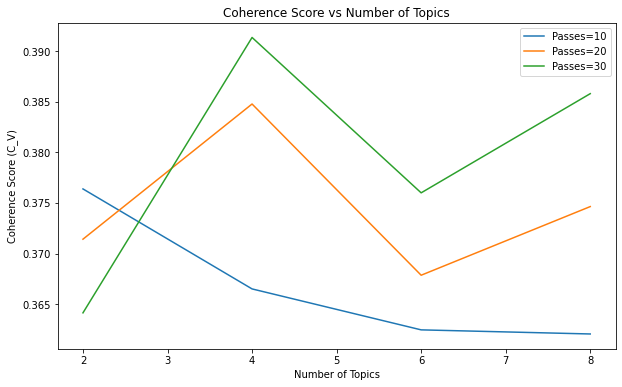

In [43]:
# Convert results to DataFrame
results_df = pd.DataFrame(results, columns=["Num_Topics", "Passes", "Coherence"])
# Plot coherence scores
plt.figure(figsize=(10, 6))
for passes in passes_list:
    subset = results_df[results_df["Passes"] == passes]
    plt.plot(subset["Num_Topics"], subset["Coherence"],
label=f'Passes={passes}')
plt.title('Coherence Score vs Number of Topics')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence Score (C_V)')
plt.legend()
plt.show()

In [45]:
# 최적화 결과 검증
optimal_num_topics = 4
optimal_passes = 30

final_lda_model = gensim.models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=optimal_num_topics,
    passes=optimal_passes,
    random_state=42
)

# display top words for each topic
for idx, topic in final_lda_model.print_topics(-1):
    print(f'Topic: {idx}: {topic}')

Topic: 0: 0.077*"account" + 0.021*"bank" + 0.019*"customer" + 0.019*"service" + 0.016*"support" + 0.014*"card" + 0.013*"help" + 0.012*"email" + 0.012*"even" + 0.011*"get"
Topic: 1: 0.029*"card" + 0.022*"payment" + 0.017*"pay" + 0.015*"credit" + 0.015*"get" + 0.014*"never" + 0.013*"use" + 0.013*"back" + 0.013*"charge" + 0.012*"account"
Topic: 2: 0.024*"time" + 0.022*"number" + 0.021*"phone" + 0.018*"get" + 0.017*"password" + 0.016*"log" + 0.014*"try" + 0.013*"even" + 0.013*"keep" + 0.012*"code"
Topic: 3: 0.031*"account" + 0.028*"use" + 0.018*"day" + 0.016*"people" + 0.016*"transfer" + 0.013*"like" + 0.012*"even" + 0.012*"get" + 0.012*"fund" + 0.012*"hold"


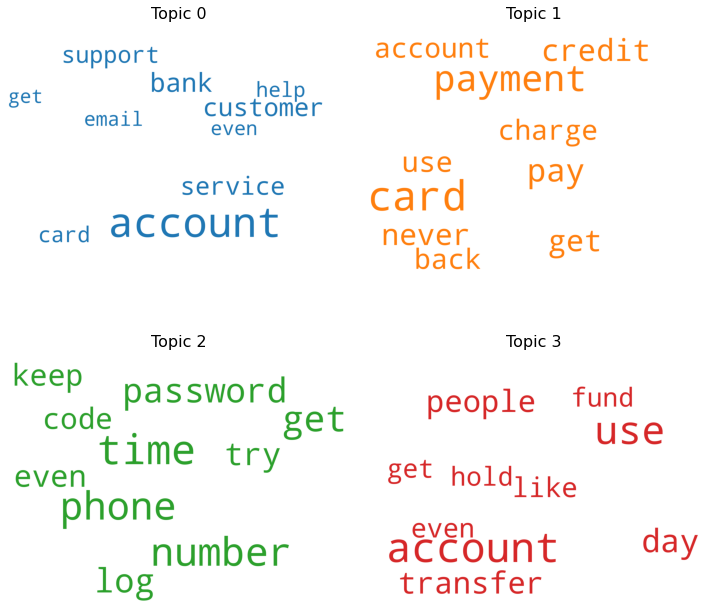

In [47]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()] # more colors: 'mcolors.XKCD_COLORS'
cloud = WordCloud(stopwords = stopwords, background_color='white', width=2500,
height=1800,
max_words=30, colormap='tab10',color_func=lambda *args, **kwargs: cols[i],
prefer_horizontal=1.0)
topics = final_lda_model.show_topics(formatted=False)
fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)
for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()